# **Correlators of the color electric fields in the Glasma**

Electric fields correlators of the Glasma $\langle E(\tau_\mathrm{form})E(\tau)\rangle$, as a function of proper time $\tau$, evaluated starting from a formation time $\tau_{\mathrm{form}}$, averaged over the transverse simulation plane where the fields reside. In this example, the choice for the saturation scale $Q_s$ is suitable for a $\mathrm{Pb}\text{-}\mathrm{Pb}$ collision at LHC energy $\sqrt{s}=5.02\,\mathrm{TeV}$.

Import all the necessary modules and packages.

In [2]:
# Set environment variables 
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["GAUGE_GROUP"] = "su3"
os.environ["PRECISION"] = "double"

# Import curraun and other packages
import sys
sys.path.append('..')

import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False
from curraun.electric_fields import ElectricFields
from curraun.electric_fields_correlators import ElectricFieldsCorrelators

from curraun.numba_target import use_cuda, use_numba
if use_cuda:
    from numba import cuda

import numpy as np
import pickle
from tqdm import tqdm

Using CUDA
Using SU(3)
Using double precision
Using double precision


Simulation routine for a single event, where all the parameters are stored in a dictionary.

In [3]:
# Define hbar*c [GeV*fm]
hbarc = 0.197326 

def simulate(p):    
    # Derived parameters
    a = p['L'] / p['N']
    E0 = p['N'] / p['L'] * hbarc
    p['E0'] = E0
    DT = 1.0 / p['DTS']
    maxt = int(p['TMAX'] / a) * p['DTS']
    formt = int(p['TFORM'] / a) * p['DTS']

    s = core.Simulation(p['N'], DT, p['G'])
    va = mv.wilson(s, mu=p['MU'] / E0, m=p['M'] / E0, uv=p['UV'] / E0, num_sheets=p['NS'])
    vb = mv.wilson(s, mu=p['MU'] / E0, m=p['M'] / E0, uv=p['UV'] / E0, num_sheets=p['NS'])
    initial.init(s, va, vb)

    elfields = ElectricFields(s)
    elfieldscorr = ElectricFieldsCorrelators(s)

    if use_cuda:
        s.copy_to_device()

    tau = []
    corr_ex, corr_ey, corr_ez  = [], [], []

    for t in range(maxt):
        core.evolve_leapfrog(s)

        if t==formt:  
            elfields = elfields.compute()
            Exform, Eyform, Ezform = elfields[:, 0], elfields[:, 1], elfields[:, 2]

        elif t>=formt:
            ExformEx, EyformEy, EzformEz = elfieldscorr.compute(Exform, Eyform, Ezform)
            # Fields correlator units [GeV / fm^3]
            units = E0 ** 4 / hbarc ** 3
            corr_ex.append(ExformEx * units)
            corr_ey.append(EyformEy * units)
            corr_ez.append(EzformEz * units)

            current_tau = t / p['DTS'] * a
            tau.append(current_tau)

    if use_cuda:
        s.copy_to_host()
        
    return p, s, tau, corr_ex, corr_ey, corr_ez

Parameters used in the simulation.

In [4]:
# Number of color sheets
ns = 50
# Ratio Qs/g^2\mu
factor = 0.8
# Mass number for Pb
A = 207
# Center-of-mass energy for Pb-Pb at 5.02 TeV [GeV]
sqrts = 5020
# Saturation scale [GeV]
Qs = np.sqrt(0.13 * A**(1/3) * sqrts**0.25)		
# Running coupling constant
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))		
# MV model parameter [GeV]
mu = Qs / (g**2 * factor)	
# Infrared regulator [GeV]
m = 0.1 * g**2 * mu   

# Formation times [GeV/fm]
taus_form = [0, 0.05, 0.1]
# Simulation time [GeV/fm]
tau_s = 0.3

# Length of simulation box [fm]
L = 15
# Number of discretization points
N = 1024
# Numerical time interval
DTS = 16
# Number of events
n_events = 20

Running the simulation for multiple events and various values of formation times.

In [5]:
for tau_form in taus_form:
    print("Formation time = {:1.2f} [GeV/fm]".format(tau_form))

    all_corr_ex, all_corr_ey, all_corr_ez = [], [], []

    # Standard MV model paramaters
    p = {
        # Parameters for simulation box
        'L':    L,           # transverse size [fm]
        'N':    N,            # lattice size
        'DTS':  DTS,             # time steps per transverse spacing
        'TMAX': tau_s,          # max. proper time (tau) [fm/c]
        'TFORM': tau_form,       # formation time of the HQ [fm/c]

        # Parameters for MV model
        'G':    g,            # YM coupling constant
        'MU':   mu,             # MV model parameter [GeV]
        'M':    m,              # IR regulator [GeV]
        # 'UV':   10000.0,      # UV regulator [GeV]
        'UV':   10.0, 
        'NS':   ns,             # number of color sheets
    }

    with tqdm(total=n_events, file=sys.stdout) as pbar:
        for nev in range(0, n_events):
            p, s, tau, mean_corr_ex, mean_corr_ey, mean_corr_ez = simulate(p)

            all_corr_ex.append(mean_corr_ex)
            all_corr_ey.append(mean_corr_ey)
            all_corr_ez.append(mean_corr_ez)

            pbar.set_description('Event {} / {}'.format(nev+1, n_events))
            pbar.update(1)

    avg_corr_ex, avg_corr_ey, avg_corr_ez = np.mean(all_corr_ex, axis = 0), np.mean(all_corr_ey, axis = 0), np.mean(all_corr_ez, axis = 0)
    std_corr_ex, std_corr_ey, std_corr_ez = np.std(all_corr_ex, axis = 0), np.std(all_corr_ey, axis = 0), np.std(all_corr_ez, axis = 0)

    output = {}
    output["avg_corr_ex"], output["std_corr_ex"] = avg_corr_ex, std_corr_ex
    output["avg_corr_ey"], output["std_corr_ey"] = avg_corr_ey, std_corr_ey
    output["avg_corr_ez"], output["std_corr_ez"] = avg_corr_ez, std_corr_ez

    fname = "./elfieldscorr_tauform_{:1.2f}.pickle".format(tau_form)
    pickle.dump(output, open(fname, "wb"))
    print("Output: {}".format(fname))

Formation time = 0.00 [GeV/fm]
Event 20 / 20: 100%|██████████| 20/20 [14:07<00:00, 42.39s/it]
Output: ./elfieldscorr_tauform_0.00.pickle
Formation time = 0.05 [GeV/fm]
Event 20 / 20: 100%|██████████| 20/20 [13:35<00:00, 40.77s/it]
Output: ./elfieldscorr_tauform_0.05.pickle
Formation time = 0.10 [GeV/fm]
Event 20 / 20: 100%|██████████| 20/20 [13:14<00:00, 39.70s/it]
Output: ./elfieldscorr_tauform_0.10.pickle


Read data from files.

In [8]:
taus_form = [0, 0.05, 0.1]
fnames = ["elfieldscorr_tauform_{:1.2f}.pickle".format(tau_form) for tau_form in taus_form]
ress = []
for fname in fnames:
    res = pickle.load(open("./{}".format(fname), "rb"))
    ress.append(res)

Various commands for plotting. Extract the decay time for the correlator evaluated since $\tau_\mathrm{form}=0\,\mathrm{[GeV/fm]}$, which yields $\tau_\mathrm{decay}\approx 0.04\,\mathrm{[GeV/fm]}$.

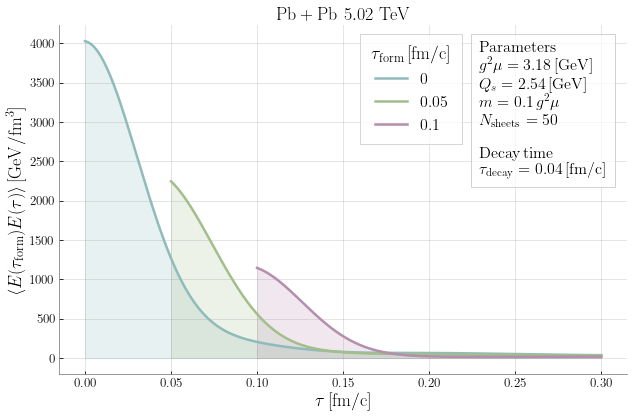

In [50]:
# Hide a warning from scipy.optimize
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib import rc
import scipy.optimize as opt

plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams.update({'font.size':13})

plt.figure()
plt.title(r'$\mathrm{Pb+Pb\,\,5.02\,\,TeV}$', size = 18)
plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 18)
plt.ylabel(r'$\Big\langle E(\tau_\mathrm{form})E(\tau)\Big\rangle\,\mathrm{[GeV/fm^3]}$', size = 18)

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray') 
ax.tick_params(direction='in', grid_color='gray', grid_alpha=0.5)
# ax.tick_params(direction='in', colors='gray',grid_color='gray', grid_alpha=0.5)
plt.grid(color = 'gray', linestyle = '-', linewidth = 1, alpha=0.2)

colors = ['#8FBCBB', '#A3BE8C', '#B48EAD']
tau_labels = [r'$0$', r'$0.05$', r'$0.1$']

taus_decay = []
for i, r in enumerate(ress):

    avg_corr = r["avg_corr_ex"] + r["avg_corr_ey"] + r["avg_corr_ez"]
    std_corr = r["std_corr_ex"] + r["std_corr_ey"] + r["std_corr_ez"]
    a = L/N
    maxt = int(tau_s / a) * DTS
    formt = int(taus_form[i] / a) * DTS
    tau = np.linspace(taus_form[i], tau_s, maxt-formt-1)

    plt.plot(tau, avg_corr, '-', color = colors[i], markersize = 0, linewidth = 2.5, label = tau_labels[i])
    # plt.fill_between(tau, avg_corr-std_corr, avg_corr+std_corr, color = colors[i], alpha=0.2)
    plt.fill_between(tau, avg_corr, color = colors[i], alpha=0.2)

    def func(tau, corr, tau_decay, const):
        return corr*np.exp(tau*tau_decay) + const

    popt, pcov = opt.curve_fit(func, tau, avg_corr)
    corr, tau_decay, const = popt
    taus_decay.append(-1/tau_decay)

textstr = '\n'.join((
    r'$\mathrm{Parameters}$',
    r'$g^2\mu=%.2f\,\mathrm{[GeV]}$' % (g*g*mu, ),
    r'$Q_s=%.2f\,\mathrm{[GeV]}$' % (Qs, ),
    r'$m=0.1\,g^2\mu$',
    r'$N_\mathrm{sheets}=50$',
    '',
    r'$\mathrm{Decay\,time}$',
    r'$\tau_\mathrm{decay}=%.2f\,\mathrm{[fm/c]}$' % (taus_decay[0], )))
props = dict(boxstyle='square', facecolor='white', alpha=0.7, edgecolor='silver', pad=0.5)
ax.text(0.74, 0.957, textstr, transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=props)

leg = ax.legend(fontsize = 16, loc = 'upper center', bbox_to_anchor=(0.62,0.985))
leg.get_frame().set_boxstyle('square')
leg.set_title(r'$\tau_\mathrm{form}\,\mathrm{[fm/c]}$',prop={'size':18})
plt.tight_layout()

plt.show()